In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Datasets/LWF_DATASET/lfw.zip

In [3]:
import torch
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.transforms as transforms
import torch.autograd as Variable
import torch.optim as optim

In [4]:
path_lfw_folder='./gdrive/MyDrive/Datasets/LWF_DATASET'

In [5]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),                    
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accuracy': val_acc}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    # save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_accuracy']
    print(f'Model loaded from <== {save_path}')
    
    return val_acc

In [6]:
class LFW(Dataset):
  def __init__(self,root_dir,txt_path,transforms1,transforms2):  ######### 
    self.transform1=transform1
    self.transform2=transform2
    self.root_dir=root_dir

    with open(txt_path) as f:
      lines=f.readlines()

      self.pair_imgs_label=[ line.split() for line in lines]

  def __len__(self):
    return len(self.pair_imgs_label)

  def __getitem__(self,idx):
    img1_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][0])
    img2_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][1])
    label= float(self.pair_imgs_label[idx][2])
    
    img1=cv2.imread(img1_path)
    img1=img1.astype(np.float)/255                                   #
    img1=cv2.resize(img1,(128,128),interpolation=cv2.INTER_AREA)
    img1=self.transform1(img1)
    
    img2=cv2.imread(img2_path)
    img2=img2.astype(np.float)/255
    img2=cv2.resize(img2,(128,128),interpolation=cv2.INTER_AREA)
    img2=self.transform1(img2)
    
    return img1,img2,torch.from_numpy(np.array([label], dtype=np.float32))

In [7]:
class Rescale(object):                                          ###################################
    def __call__(self, img):
        if random.random()<0.7:
            f = round(0.1*random.randint(7, 13),2)
            if f>1:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_CUBIC)
                a = int(round((f*128-128)/2))
                img = img[a:a+128,a:a+128]
            else:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_AREA)
                a= int(round((128-f*128)/2))
                temp=np.zeros([128,128,3],dtype=np.uint8)
                temp.fill(0) 
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        temp[i+a,j+a]=img[i,j]
                img=temp
        return img

class Flip(object):
    def __call__(self,img):
        if random.random()<0.7:
            return cv2.flip(img,1)
        return img
        
class Rotate(object):
    def __call__(self,img):
        if random.random()<0.7:
            angle=random.random()*60-30
            rows,cols,cn = img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            img = cv2.warpAffine(img,M,(cols,rows))
            return img
        return img

class Translate(object):
    def __call__(self,img):
        if random.random()<0.7:
            x=random.random()*20-10
            y=random.random()*20-10
            rows,cols,cn = img.shape
            M= np.float32([[1,0,x],[0,1,y]])
            img = cv2.warpAffine(img,M,(cols,rows))
        return img

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    self.conv1 = nn.Sequential(
        # input = 3*128*128
        nn.Conv2d(3,24,5,1,2),
        # output= 24*128*128
        nn.ReLU(),
        nn.BatchNorm2d(24),
        # input = 24*128*128
        nn.MaxPool2d(3,2),
        # output = 24*63*63
        )
    self.conv2 = nn.Sequential(
        # input = 24*63*63
        nn.Conv2d(24,48,5,1,2),
        # output = 48*63*63
        nn.ReLU(),
        nn.BatchNorm2d(48),
        # input = 48*63*63
        nn.MaxPool2d(3,2),
        # output= 48*31*31
        )
    self.conv3 = nn.Sequential(
        # input = 48*31*31
        nn.Conv2d(48,128,3,2),
        # output= 128*15*15
        nn.ReLU(),
        nn.BatchNorm2d(128),
        )
    self.conv4 =nn.Sequential(
        # input = 128*15*15
        nn.Conv2d(128,192,3,1),
        # input = 192*13*13
        nn.ReLU(),
        nn.BatchNorm2d(192),
        )
    self.conv5 =nn.Sequential(
        # input = 192*13*13
        nn.Conv2d(192,128,3,1),
        # input = 128*11*11
        nn.ReLU(),
        nn.BatchNorm2d(128),
        )
    # self.fc1_sim = nn.Sequential(
    #     nn.Linear(128*11*11,4096),
    #     nn.Sigmoid(),
    #     )   
    # self.fc2_sim = nn.Sequential(
    #     nn.Linear(4096,1),
    #     )
    self.fc1= nn.Sequential(
        nn.Linear(128*11*11,1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
    )
    self.fc2= nn.Sequential(
        nn.Linear(2048,1),
        nn.Sigmoid(),
    )

  def convs(self,x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=x.view(-1,128*11*11)
    x=self.fc1(x)
    return x

  def forward(self,x1,x2):
    x1= self.convs(x1)
    x2= self.convs(x2)

    x=torch.cat((x1,x2),1)
    x=self.fc2(x)

    # For distance function method
    # x=torch.abs(x1-x2)
    # x= self.fc2(x)

    return x

In [ ]:
def train(model,train_loader,val_loader,num_epochs,criterion,save_name):
  train_losses=[]
  val_losses=[]
  mx_val_accuracy=-1
  for epoch in range(num_epochs):
    running_loss=0.0
    print("Starting epoch " + str(epoch+1))
    model.train()
    for i,data in enumerate(train_loader,0):
      imgs1,imgs2,labels=data
      
      imgs1=imgs1.to(device=device, dtype=torch.float)
      imgs2=imgs2.to(device=device, dtype=torch.float)
      labels=labels.to(device=device, dtype=torch.float)

      optimizer.zero_grad()
      outputs=model(imgs1,imgs2)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    val_running_loss=0.0                                                            ########################### 
    correct=0
    with torch.no_grad():
      model.eval()
      for i,data in enumerate(val_loader,0):
        imgsV1,imgsV2,labelsV= data
        
        imgsV1=imgsV1.to(device=device, dtype=torch.float)
        imgsV2=imgsV2.to(device=device, dtype=torch.float)
        labelsV=labelsV.to(device=device, dtype=torch.float)

        outputs=model(imgsV1,imgsV2)
        loss=criterion(outputs,labelsV)

        # val accuracy calc
        outputs=outputs.to(device=device, dtype=torch.float)
        
        for j,op in enumerate(outputs,0):

          if(op[0]<0.5):
            #0 predicted
            if labelsV[j]==0:           ###########
              correct+=1
          else:
            # 1 predicted
            if labelsV[j]==1:
              correct+=1
        val_running_loss+=loss.item()
    val_accuracy= correct/len(val_loader)
    avg_val_loss= val_running_loss/len(val_loader)
    val_losses.append(avg_val_loss)
    ## val acc
    if mx_val_accuracy<val_accuracy:
      mx_val_accuracy=val_accuracy
      save_checkpoint(save_name, model, optimizer, mx_val_accuracy)

    print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
  
  print("Training completed.")
  
  fig = plt.figure()
  ax = plt.subplot(111)
  ax.plot(train_losses)
  ax.plot(val_losses)     ###############3
  plt.xlabel('Steps')  
  plt.ylabel('Loss')  
  fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

  return train_losses,val_losses,mx_val_accuracy


In [9]:
transform1 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
transform2 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataSize = 2200 # self-defined dataset size for training                                                               ########################### NEW
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(train_dataSize * TRAIN_PCT)
val_size = train_dataSize - train_size   

lfw_dataset = LFW('./lfw/lfw',os.path.join(path_lfw_folder,'lfw_train_pairs.txt'),transform1,transform2)                                 ###############

train_set, val_set = random_split(lfw_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128 , num_workers=2)    # shuffle=true removed
val_loader   = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=2)

In [10]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001  # 0.0006
num_epoches = 20    # 50
siameseBaseModel=Net()
siameseBaseModel.to(device)

optimizer = optim.Adam(siameseBaseModel.parameters(), lr)
criterion = nn.BCELoss() 
save_path=os.path.join(path_lfw_folder,'siameseBaseModel.pt')

count_parameters(siameseBaseModel)

Running on gpu
The model architecture:

 Net(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_st

Starting epoch 1
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
Epoch [1/20],Train Loss: 1.1599, Valid Loss: 0.93893888
Starting epoch 2
Epoch [2/20],Train Loss: 0.7290, Valid Loss: 0.74010092
Starting epoch 3
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
Epoch [3/20],Train Loss: 0.7225, Valid Loss: 0.71418298
Starting epoch 4
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
Epoch [4/20],Train Loss: 0.7051, Valid Loss: 0.70032621
Starting epoch 5
Epoch [5/20],Train Loss: 0.6900, Valid Loss: 0.70537667
Starting epoch 6
Epoch [6/20],Train Loss: 0.6965, Valid Loss: 0.68552518
Starting epoch 7
Epoch [7/20],Train Loss: 0.6956, Valid Loss: 0.74143876
Starting epoch 8
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
Epoch [8/20],Train Loss: 0.6980, Valid Loss: 0.67731003
Starting epoch 9
Epoch [9/20],Train Loss: 0.6872, Valid Loss: 0.68714764
Starting epoch 10
Model saved to ==

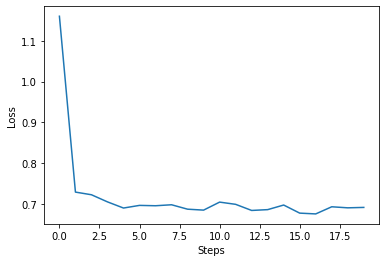

In [ ]:
train_loss_his,val_loss_his,mx_val_accuracy_train=train(siameseBaseModel,train_loader,val_loader,num_epoches,criterion,save_path)

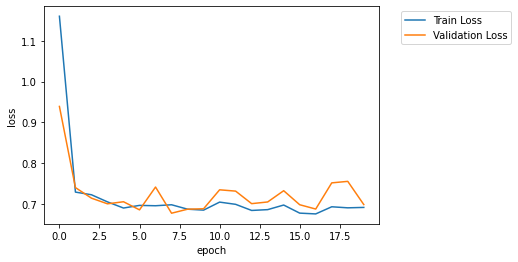

In [ ]:
#plotting of training and validation loss                          ########################### 
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_his, label='Train Loss')
plt.plot(val_loss_his, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [24]:
def test(model,test_loader):
    with torch.no_grad():
      model.eval()
      correct=0
      cnt=0
      print("strating testing:")        
      for i,data in enumerate(test_loader,0):
        imgs1,imgs2,labels=data
        
        imgs1=imgs1.to(device=device, dtype=torch.float)
        imgs2=imgs2.to(device=device, dtype=torch.float)
        labels=labels.to(device=device, dtype=torch.float)

        outputs=model(imgs1,imgs2)
        # test accuracy calc
        outputs=outputs.to(device=device, dtype=torch.float)
        for j,op in enumerate(outputs,0):
          cnt+=1
          if(op[0]<0.5):
            #0 predicted
            if labels[j]==0:           ###########
              correct+=1
          else:
            # 1 predicted
            if labels[j]==1:
              correct+=1
    test_accuracy= correct/cnt

    return test_accuracy


In [25]:
root_path_to_saved_models='./gdrive/MyDrive/Datasets/LWF_DATASET/models'
path_to_model_from_saved_model_dir='Siamese_net_lfw_base_model_2_with_validation_early_stopping/siameseBaseModel.pt'
path_to_chosen_model= os.path.join(root_path_to_saved_models,path_to_model_from_model_dir)
# print(path_to_chosen_model )

In [26]:
load_model=Net().to(device)
load_optimizer=optim.Adam(load_model.parameters(),lr=0.001)
mx_val_acc=load_checkpoint(load_model,load_optimizer,path_to_chosen_model)

transform1 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
transform2 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_set= LFW('./lfw/lfw',os.path.join(path_lfw_folder,'lfw_test_pairs.txt'),transform1,transform2)
test_loader= DataLoader(test_set,batch_size=8,num_workers=2)

train_accuracy= test(load_model,train_loader)
test_accuracy=test(load_model,test_loader)


print("Train accuracy is: ",100*train_accuracy)
print("Max val accuracy during training: ",100*mx_val_acc)
print("Test accuracy is: ",100*test_accuracy)

Model loaded from <== ./gdrive/MyDrive/Datasets/LWF_DATASET/models/Siamese_net_lfw_base_model_2_with_validation_early_stopping/siameseBaseModel.pt
strating testing:
strating testing:
Train accuracy is:  53.75
Max val accuracy during training:  58.18181818181818
Test accuracy is:  54.1
